# Calculate PPD distribution from data

In [1]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using CSV
using DataFrames
using CairoMakie
using StatsBase
using JuMP
using HiGHS

  Activating project at `c:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Manifest.toml`


Status `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  [336ed68f] CSV v0.10.15
  [13f3f980] CairoMakie v0.13.1
  [a93c6f00] DataFrames v1.7.0
  [87dc4568] HiGHS v1.13.0
  [682c06a0] JSON v0.21.4
  [4076af6c] JuMP v1.23.6
⌃ [b8f27783] MathOptInterface v1.35.1
  [2d871509] OptHP v1.0.0-DEV `OptHP`
  [295af30f] Revise v3.7.2
  [2913bbd2] StatsBase v0.34.4
  [f269a46b] TimeZones v1.20.0
  [ade2ca70] Dates
Info Packages marked with ⌃ have new versions available and may be upgradable.


## Read data

In [7]:
df = CSV.read("data/PPD/PPD_ta_3001.csv", DataFrame)
dropmissing!(df)
select!(df, Not(:Column1))
first(df, 5)

Row,Ta,PPD
,Int64,Float64
1,15,35.9
2,15,38.0
3,15,25.3
4,15,51.8
5,15,5.3


## Calculate interquartiles ranges

In [ ]:
# summarystats(df[!, :PPD])

In [8]:
dfg = groupby(df, :Ta)

# compute quantiles
dfg = combine(dfg) do df
    # filter outliers 3 std
    df = filter(:PPD => <(3 * std(df.PPD)), df)

    # Ti min max Q1 Q2 Q3 
    (
        min = quantile(df.PPD, max(0.0,0.25 - 1.5 * iqr(df.PPD))),
        max = quantile(df.PPD, min(1.0,0.75 + 1.5 * iqr(df.PPD))),
        Q1 = quantile(df.PPD, 0.25), 
        Q2 = quantile(df.PPD, 0.50),
        Q3 = quantile(df.PPD, 0.75)
    )
end

# save to CSV
CSV.write("data/PPD/PPD_quantiles.csv", dfg)

"data/PPD/PPD_quantiles.csv"

## Build convex outer approximation of the PPD medians

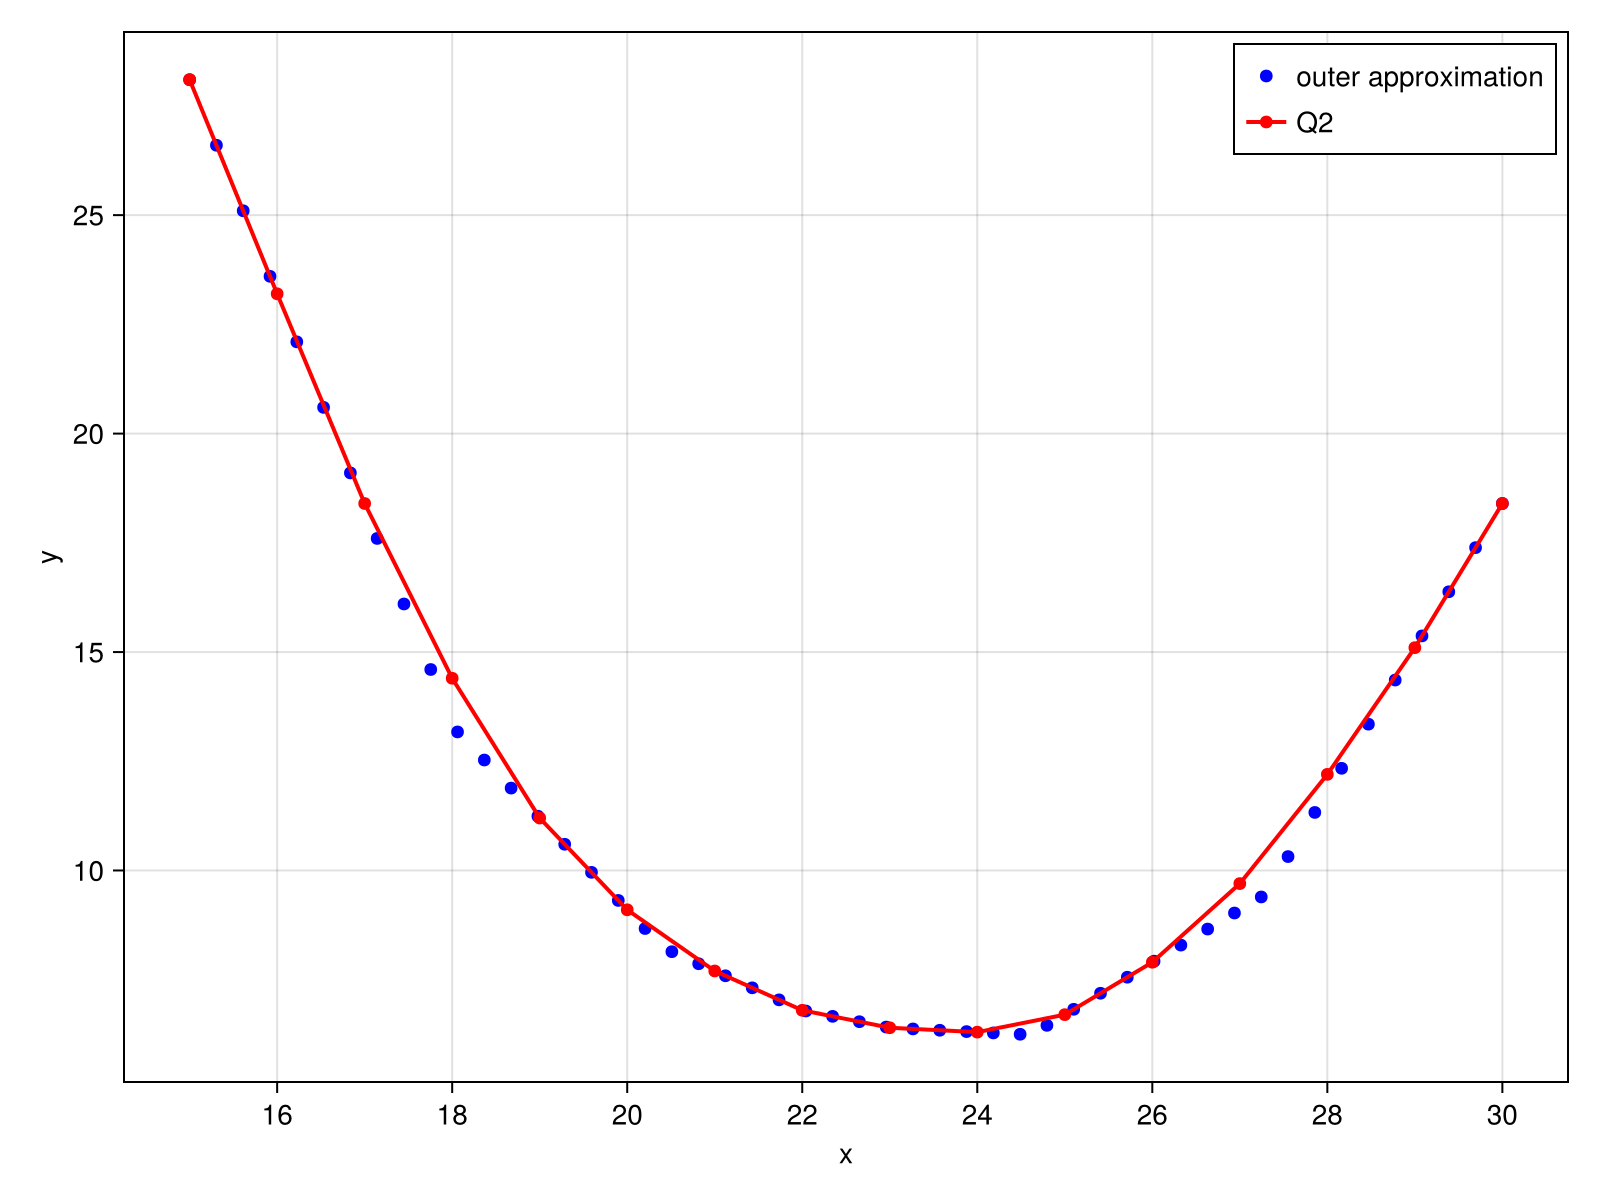

In [9]:
function outer_approximate_x(x̄, medians::Vector{Tuple{Int64, Float64}})

    # compute ray f(x) through two median points that are adjacent
    f(x, (x1, y1), (x2, y2)) = y1 + (y2 - y1) / (x2 - x1) * (x - x1)

    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, x)
    @variable(model, y)

    # generate one constraint for each pair of adjacent medians
    # for i in 3:length(medians) - 3
    # for i in 1:3:length(medians) - 1
    for i in [1,5,7,8,9,11,15]
        @constraint(model, y >= f(x, medians[i], medians[i + 1]))
    end

    @objective(model, Min, y)
    @constraint(model, x == x̄)  # <-- a trivial constraint just for testing.
    optimize!(model)
    @assert is_solved_and_feasible(model)
    return value(y)
end

fig = Figure(; size = (800, 600))
ax = Axis(fig[1, 1]; xlabel = "x", ylabel = "y")

for x̄ in range(; start = 15, stop = 30, length = 50)
    ȳ = outer_approximate_x(x̄, [(x, y) for (x, y) in zip(dfg.Ta, dfg.Q2)])
    scatter!(ax, [x̄], [ȳ]; label = "outer approximation", color = :blue)
end



# plot medians using scatterlines
scatterlines!(ax, dfg.Ta, dfg.Q2; label = "Q2", color = :red, linewidth = 2)

axislegend(ax, unique = true)

fig

In [ ]:
# function outer_approximate_x_squared(x̄, f, ∇f)
#     model = Model(HiGHS.Optimizer)
#     # set_silent(model)
#     @variable(model, 15 <= x <= 30)
#     @variable(model, y)
#     # Tip: try changing the number of points x_k
#     @constraint(model, [x_k in 15:1:30], y >= f(x_k) + ∇f(x_k) * (x - x_k))
#     @objective(model, Min, y)
#     @constraint(model, x == x̄)  # <-- a trivial constraint just for testing.
#     optimize!(model)
#     @assert is_solved_and_feasible(model)
#     return value(y)
# end

In [ ]:
# fig = Figure(; size = (800, 600))
# ax = Axis(fig[1, 1]; xlabel = "x", ylabel = "y")

# # plot medians using scatterlines
# scatterlines!(ax, dfg.Ta, dfg.Q2; label = "Q2", color = :black)

# # fit quadratic formula to medians
# x = dfg.Ta
# y = dfg.Q2

# # measurement matrix 
# A = hcat(ones(length(x)), x, x.^2, x.^3, x.^4)

# # least squares solution
# β = A \ y

# # plot quadratic
# # lines!(ax, 15:0.01:30, x -> β[1] + β[2] * x + β[3] * x^2 + β[4] * x^3; label = "x^2", color = :red)

# f = x -> β[1] + β[2] * x + β[3] * x^2 + β[4] * x^3 + β[5] * x^4
# ∇f = x -> β[2] + 2 * β[3] * x + 3 * β[4] * x^2 + 4 * β[5] * x^3

# for x̄ in range(; start = 15, stop = 30, length = 15)
#     ȳ = outer_approximate_x_squared(x̄, f, ∇f)
#     scatter!(ax, [x̄], [ȳ]; label = "outer approximation", color = :blue)
# end

# axislegend(ax, unique = true)

# fig